In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import qiskit
from qiskit import transpile, assemble, IBMQ
from qiskit.visualization import *
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeBelem

In [3]:
provider = IBMQ.load_account()

In [116]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        # print(f"Result is {result}")
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

Expected value for rotation pi 0.4


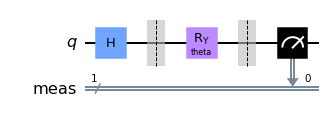

In [117]:
# Using a noisy simulator
noisy_backend = FakeBelem()
simulator = AerSimulator.from_backend(noisy_backend)

# simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw('mpl')

In [159]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(2, backend, shots) # initialize 2 qubit VQC
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [160]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

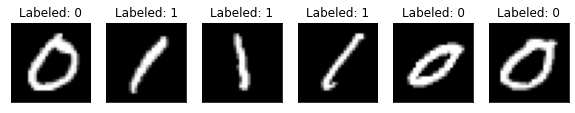

In [161]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [162]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [163]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # 6 input channels, 16 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64) # fc stands for fully connected layer
        self.fc2 = nn.Linear(64, 2) # output 1 to be run on 2 qubit VQC
        # self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)
        self.hybrid = [Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2) for i in range(2)]


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)

        # Here is where the matrixes/channels are flattened into one long vector
        x = torch.flatten(x, start_dim=1)
        # x = x.view(1, -1) # make it the same shape as output
        x = F.relu(self.fc1(x)) # ReLu is applied to fc1(x) where fc1 is channel which it takes an input of 256 and outputs a vector of a size of 64.
        x = self.fc2(x) # Final step where input is a size of 64 and output is a size of 10.

        x = torch.chunk(x, 2, dim=1)
        # x = self.hybrid(x)
        x = tuple([hybr(x_) for hybr, x_ in zip(self.hybrid, x)])
        return torch.cat(x, -1)

In [164]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
#         self.dropout = nn.Dropout2d()
#         self.fc1 = nn.Linear(256, 64)
#         self.fc2 = nn.Linear(64, 1)
#         self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = self.dropout(x)
#         x = x.view(1, -1)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         x = self.hybrid(x)
#         return torch.cat((x, 1 - x), -1)

In [165]:
model = Net()
summary(model, (1, 28, 28), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 24, 24]           156
├─Conv2d: 1-2                            [-1, 16, 8, 8]            2,416
├─Dropout2d: 1-3                         [-1, 16, 4, 4]            --
├─Linear: 1-4                            [-1, 64]                  16,448
├─Linear: 1-5                            [-1, 2]                   130
Total params: 19,150
Trainable params: 19,150
Non-trainable params: 0
Total mult-adds (M): 0.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.07
Estimated Total Size (MB): 0.11


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 24, 24]           156
├─Conv2d: 1-2                            [-1, 16, 8, 8]            2,416
├─Dropout2d: 1-3                         [-1, 16, 4, 4]            --
├─Linear: 1-4                            [-1, 64]                  16,448
├─Linear: 1-5                            [-1, 2]                   130
Total params: 19,150
Trainable params: 19,150
Non-trainable params: 0
Total mult-adds (M): 0.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.07
Estimated Total Size (MB): 0.11

In [166]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward() # computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation.
        # Optimize the weights
        optimizer.step() # causes the optimizer to take a step based on the gradients of the parameters.
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/var/folders/sy/rym6stnx3d37k0n9lzxv5wbc0000gn/T/ipykernel_27707/3728979229.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -9.9956
Training [10%]	Loss: -10.5720
Training [15%]	Loss: -10.5989
Training [20%]	Loss: -10.6657
Training [25%]	Loss: -10.7344
Training [30%]	Loss: -10.8710
Training [35%]	Loss: -10.9029
Training [40%]	Loss: -10.9046
Training [45%]	Loss: -10.9347
Training [50%]	Loss: -10.9463
Training [55%]	Loss: -10.9376
Training [60%]	Loss: -10.9688
Training [65%]	Loss: -10.9593
Training [70%]	Loss: -10.9824
Training [75%]	Loss: -10.9819
Training [80%]	Loss: -10.9803
Training [85%]	Loss: -10.9878
Training [90%]	Loss: -10.9814
Training [95%]	Loss: -10.9890
Training [100%]	Loss: -10.9902


Text(0, 0.5, 'Negative Log Likelihood Loss')

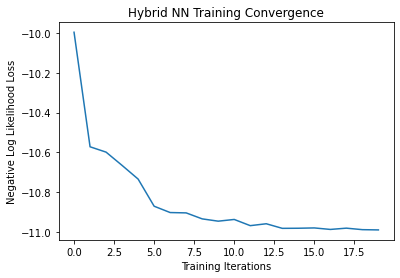

In [167]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Negative Log Likelihood Loss')

In [168]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -10.9144
	Accuracy: 50.0%


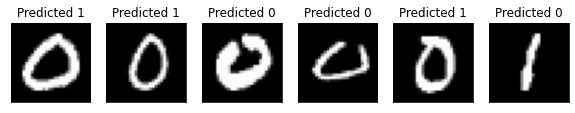

In [169]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1